# Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from pycaret.regression import setup
import statsmodels.api as sm
from joblib import dump

# Funciones auxiliares

In [2]:
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    #from matplotlib.colors import ListedColormap
    #cm_blue_orange = ListedColormap(['tab:blue', 'orange'])
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap con Valores Numéricos y Colores')
    # Mostrar el gráfico
    plt.show()

In [3]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [4]:
# # Función para entrenar y evaluar un modelo
# def train_evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE
#     r2 = r2_score(y_test, y_pred)
#     return rmse, r2

In [5]:
# Función para entrenar y evaluar el modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    return rmse_train, r2_train, rmse_test, r2_test

In [6]:
'''eliminación_hacia_atras https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html

dataset: datos a entrenar (dataframe)
level_significance: nivel de significancia, por default 0.05

Este método hace la eliminación hacia atrás de la regresión lineal múltiple de acuerdo a un nivel de significancia (p valor)
utilizando como métrica al valor r cuadrado ajustado.
Return: Arroja una lista de los nombres de las variables más significativas para el modelo'''
def eliminacion_hacia_atras(dataset:pd.DataFrame, target:str, level_significance = 0.05):
    X = dataset.loc[:, (dataset.columns != target)]
    y = dataset.loc[:, target]
    columnas_X = X.columns.tolist()
    
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=123)
    X_train = pd.DataFrame(X_train, columns=X.columns)  # Reconstruir DataFrame para entrenamiento
    y_train = pd.Series(y_train)
    y_train.name = target

    #preparar los predictores para función OLS
    #Se agrega una columna de '1' (constante) al inicio a los predictores para el método OLS (obligatorio)
    X_OLS = sm.add_constant(X_train)
    y_OLS = y_train
    
    rsquared_adj_dictionary = {} #clave: r cuadrado ajustado, valor: nombre de las variable independiente

    while len(columnas_X) > 0:
        regression_OLS = sm.OLS(endog = y_OLS, exog = X_OLS).fit()
        
        pvalues = regression_OLS.pvalues.iloc[1:] #Se tiene los p valores del modelo // No se escoge la columna llena de 1 (constante)
        max_p_value = max(pvalues) #el mayor p valor
        model_rsquared_adj = regression_OLS.rsquared_adj # r2 ajustado del modelo

        feature_to_remove = pvalues.idxmax() #nombre de la variable a eliminar (p valor max)
        rsquared_adj_dictionary[model_rsquared_adj] = columnas_X.copy()

        #Print de los resultados estadísticos (opcional - se puede comentar)
        print('*'*80)
        print(regression_OLS.summary(), end= '\n'*2)
        print('Criterio de Información de Akaike (AIC), debe ser preferiblemente el menor entre todos los modelos:', regression_OLS.aic)
        print(rsquared_adj_dictionary[model_rsquared_adj])
        print('*'*80, end= '\n'*4)
        #Print de los resultados estadísticos (opcional - se puede comentar)

        if max_p_value > level_significance:

            X_OLS = X_OLS.drop(columns=[feature_to_remove])
            columnas_X.remove(feature_to_remove)
        else: #si ya se superó el umbral de significancia se para el ciclo while
            break

    maximo_r2_adj = max(rsquared_adj_dictionary)

    #Print de los resultados (opcional - se puede comentar)
    print('//ESTE ES EL MEJOR MODELO')
    print(f"R^2: {maximo_r2_adj}, variables de este modelo: {rsquared_adj_dictionary[maximo_r2_adj]}")
    #Print de los resultados (opcional - se puede comentar)

    return rsquared_adj_dictionary[maximo_r2_adj] + [target]

# Preprocesamiento

In [7]:
average_cluster_3=pd.read_csv("../data/interim/closest_series_cluster_3.csv",parse_dates=["Date/Time"])

In [8]:
#eliminamos la columna type building porque no es relevante 
average_cluster_3.drop(columns=["type_building"], inplace=True)

In [9]:
average_cluster_3.shape

(8760, 7)

In [10]:
average_cluster_3.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,222.181130,41.991608,61.427277,0.0,43.513342,52.539744
1,2004-01-01 02:00:00,210.991716,43.757489,48.757221,0.0,43.513342,52.539744
2,2004-01-01 03:00:00,231.189993,52.603112,59.731578,0.0,43.513342,52.539744
3,2004-01-01 04:00:00,212.281478,44.866263,48.907560,0.0,43.513342,52.539744
4,2004-01-01 05:00:00,231.282564,51.760941,60.210417,0.0,43.513342,52.539744


In [11]:
average_cluster_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8395 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8760 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8760 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8760 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8760 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8760 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 479.2 KB


In [12]:
average_cluster_3.isna().sum()

Date/Time                                     365
Electricity:Facility [kW](Hourly)               0
Fans:Electricity [kW](Hourly)                   0
Cooling:Electricity [kW](Hourly)                0
Heating:Electricity [kW](Hourly)                0
InteriorLights:Electricity [kW](Hourly)         0
InteriorEquipment:Electricity [kW](Hourly)      0
dtype: int64

In [13]:
average_cluster_3.iloc[:5,:]

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,222.181130,41.991608,61.427277,0.0,43.513342,52.539744
1,2004-01-01 02:00:00,210.991716,43.757489,48.757221,0.0,43.513342,52.539744
2,2004-01-01 03:00:00,231.189993,52.603112,59.731578,0.0,43.513342,52.539744
3,2004-01-01 04:00:00,212.281478,44.866263,48.907560,0.0,43.513342,52.539744
4,2004-01-01 05:00:00,231.282564,51.760941,60.210417,0.0,43.513342,52.539744


In [14]:
average_cluster_3[average_cluster_3.isna().any(axis=1)]

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
23,NaT,206.989200,34.170730,53.388309,0.0,43.513342,52.539744
47,NaT,202.306539,5.275919,77.098456,0.0,43.513342,52.539744
71,NaT,189.617996,6.903223,62.972593,0.0,43.513342,52.539744
95,NaT,207.254957,18.671923,68.736637,0.0,43.513342,52.539744
119,NaT,150.738867,2.264433,29.311561,0.0,43.513342,52.539744
...,...,...,...,...,...,...,...
8663,NaT,118.749168,0.000000,0.000000,0.0,43.513342,52.539744
8687,NaT,118.570180,0.000000,0.000000,0.0,43.513342,52.539744
8711,NaT,118.561395,0.000000,0.000000,0.0,43.513342,52.539744
8735,NaT,208.309300,4.685519,83.870315,0.0,43.513342,52.539744


In [15]:
# # Imputar o eliminar valores faltantes si existen
# average_cluster_0.fillna(method='ffill', inplace=True)
average_cluster_3['Date/Time'].fillna(pd.Timestamp('2004-01-01 00:00:00'), inplace=True)

In [16]:
average_cluster_3.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [17]:
# Establecer la columna de fecha como índice
average_cluster_3.set_index('Date/Time', inplace=True)

In [18]:
# Extraer características temporales
average_cluster_3['hour'] = average_cluster_3.index.hour
average_cluster_3['day_of_week'] = average_cluster_3.index.dayofweek
average_cluster_3['month'] = average_cluster_3.index.month

In [19]:
average_cluster_3.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,,
2004-01-01 01:00:00,222.181130,41.991608,61.427277,0.0,43.513342,52.539744,1,3,1
2004-01-01 02:00:00,210.991716,43.757489,48.757221,0.0,43.513342,52.539744,2,3,1
2004-01-01 03:00:00,231.189993,52.603112,59.731578,0.0,43.513342,52.539744,3,3,1
2004-01-01 04:00:00,212.281478,44.866263,48.907560,0.0,43.513342,52.539744,4,3,1
2004-01-01 05:00:00,231.282564,51.760941,60.210417,0.0,43.513342,52.539744,5,3,1


In [20]:
average_cluster_3.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [21]:
target='Electricity:Facility [kW](Hourly)'

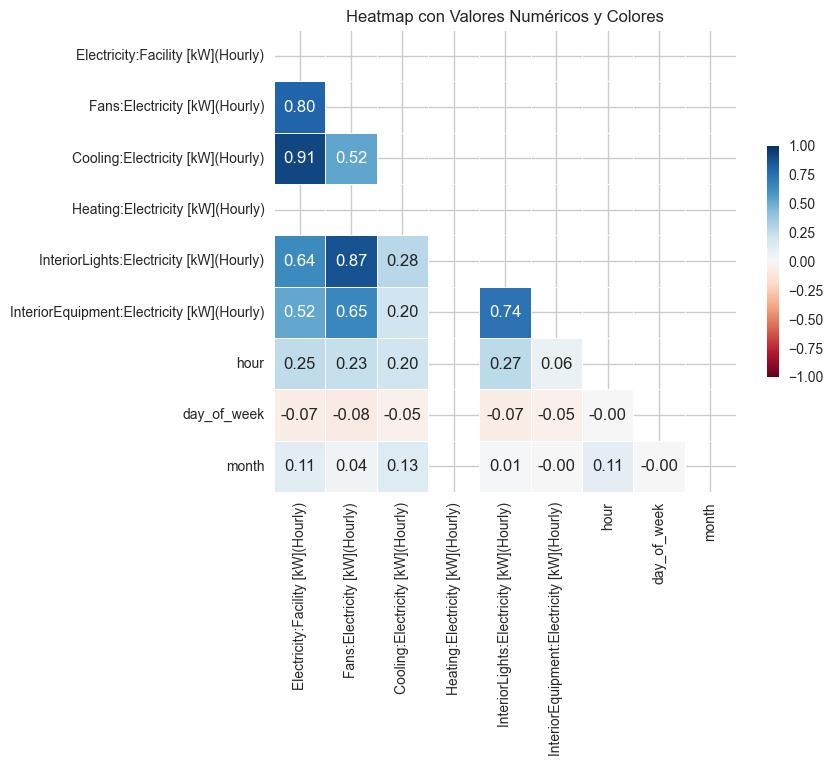

In [22]:
matriz_correlacion(average_cluster_3, target)

In [23]:
dataset_sin_correlacion = average_cluster_3.reset_index(drop=True).copy()
multicollinearity_threshold = 0.6 #definir umbral para eliminar las variables altamente correlacionadas entre sí 
sin_correlacion = setup(data = dataset_sin_correlacion, target = target, remove_multicollinearity = True, multicollinearity_threshold = multicollinearity_threshold) #se eliminan los valores con correlación mayor a "multicollinearity_threshold"

,Description,Value
0,Session id,5595
1,Target,Electricity:Facility [kW](Hourly)
2,Target type,Regression
3,Original data shape,"(8760, 9)"
4,Transformed data shape,"(8760, 7)"
5,Transformed train set shape,"(6132, 7)"
6,Transformed test set shape,"(2628, 7)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [24]:
lista_sin_correlacion = sin_correlacion.dataset_transformed.columns.to_list()
lista_sin_correlacion

['FansElectricity kW(Hourly)',
 'CoolingElectricity kW(Hourly)',
 'HeatingElectricity kW(Hourly)',
 'hour',
 'day_of_week',
 'month',
 'Electricity:Facility [kW](Hourly)']

In [25]:
lista_sin_correlacion_p=["Electricity:Facility [kW](Hourly)","Cooling:Electricity [kW](Hourly)",'Fans:Electricity [kW](Hourly)','Heating:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month']

In [26]:
dataset_sin_correlacion = dataset_sin_correlacion.loc[:,lista_sin_correlacion_p]

In [27]:
dataset_sin_correlacion.head()

,Electricity:Facility [kW](Hourly),Cooling:Electricity [kW](Hourly),Fans:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),hour,day_of_week,month
0,222.181130,61.427277,41.991608,0.0,43.513342,1,3,1
1,210.991716,48.757221,43.757489,0.0,43.513342,2,3,1
2,231.189993,59.731578,52.603112,0.0,43.513342,3,3,1
3,212.281478,48.907560,44.866263,0.0,43.513342,4,3,1
4,231.282564,60.210417,51.760941,0.0,43.513342,5,3,1


In [28]:
features_corr=dataset_sin_correlacion.drop(columns='Electricity:Facility [kW](Hourly)').copy()

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [29]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr

,feature,VIF
0,Cooling:Electricity [kW](Hourly),2.473305
1,Fans:Electricity [kW](Hourly),12.587975
2,Heating:Electricity [kW](Hourly),NaN
3,InteriorLights:Electricity [kW](Hourly),13.501683
4,hour,3.702432
5,day_of_week,2.527814
6,month,3.154971


In [30]:
features_selected_corr=features_corr.copy()
features_selected_corr.head()


,Cooling:Electricity [kW](Hourly),Fans:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),hour,day_of_week,month
0,61.427277,41.991608,0.0,43.513342,1,3,1
1,48.757221,43.757489,0.0,43.513342,2,3,1
2,59.731578,52.603112,0.0,43.513342,3,3,1
3,48.907560,44.866263,0.0,43.513342,4,3,1
4,60.210417,51.760941,0.0,43.513342,5,3,1


In [31]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

In [32]:
lista_eliminicacion_hacia_atras = eliminacion_hacia_atras(dataset_sin_correlacion,target)

********************************************************************************
                                    OLS Regression Results                                   
Dep. Variable:     Electricity:Facility [kW](Hourly)   R-squared:                       0.994
Model:                                           OLS   Adj. R-squared:                  0.994
Method:                                Least Squares   F-statistic:                 2.082e+05
Date:                               Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                                       01:17:01   Log-Likelihood:                -32360.
No. Observations:                               7008   AIC:                         6.473e+04
Df Residuals:                                   7001   BIC:                         6.478e+04
Df Model:                                          6                                         
Covariance Type:                           nonrobust                     

In [33]:
lista_eliminicacion_hacia_atras

['Cooling:Electricity [kW](Hourly)',
 'Fans:Electricity [kW](Hourly)',
 'Heating:Electricity [kW](Hourly)',
 'InteriorLights:Electricity [kW](Hourly)',
 'hour',
 'Electricity:Facility [kW](Hourly)']

In [34]:
lista_sin_correlacion_p=['Heating:Electricity [kW](Hourly)','Fans:Electricity [kW](Hourly)',"Cooling:Electricity [kW](Hourly)",'InteriorLights:Electricity [kW](Hourly)', 'hour']

In [35]:
features_predict=average_cluster_3.loc[:,lista_sin_correlacion_p].copy()

In [36]:
features_predict.columns

Index(['Heating:Electricity [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)', 'hour'],
      dtype='object')

In [37]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [38]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_predict, taget_predict, test_size=0.2, random_state=42)

In [39]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [40]:
# Definición de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('lasso', Lasso(alpha=0.01)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados y modelos entrenados
results = {}
trained_models = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    rmse_train, r2_train, rmse_test, r2_test = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {
        'RMSE Train': rmse_train, 
        'R2 Train': r2_train,
        'RMSE Test': rmse_test, 
        'R2 Test': r2_test
    }
    # Guardar el modelo entrenado en el diccionario
    trained_models[model_name] = model

In [41]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(results)
df_overfitting_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
RMSE Train,24.508893,24.508957,4.157412,42.518646,24.508893,16.897126,5.057139
R2 Train,0.994412,0.994412,0.999839,0.983181,0.994412,0.997344,0.999762
RMSE Test,23.837383,23.838192,11.829859,44.338164,23.837383,17.096283,8.904880
R2 Test,0.994724,0.994724,0.998701,0.981747,0.994724,0.997286,0.999264


# Mejorar hiperparametros

In [43]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_root_mean_squared_error',  # Usar RMSE
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [44]:
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [45]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
rmse_train_opt = np.sqrt(mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr)))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

rmse_test_opt = np.sqrt(mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr)))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'RMSE Train': rmse_train_opt,
        'R2 Train': r2_train_opt,
        'RMSE Test': rmse_test_opt,
        'R2 Test': r2_test_opt
    }
}

In [46]:
# Mostrar los resultados
print("Resultados del modelo Random Forest optimizado:")
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

Resultados del modelo Random Forest optimizado:


,Optimized Random Forest
R2 Test,0.999285
R2 Train,0.999765
RMSE Test,8.774165
RMSE Train,5.029915


In [47]:
dump(optimized_rf_model, '../models/modelo_closest_cluster_3.joblib')
dump(scaler_corr, '../models/scaler_closest_cluster_3.joblib')

['../models/scaler_closest_cluster_3.joblib']